# ZfRsoz topic modelling

## Setup

For this notebook, you need [BERTopic](https://maartengr.github.io/BERTopic/index.html). Because of its dependencies, installation isn't completely straightforward on the different platforms.

In [79]:
# nlp
# on Windows the use of conda was required:  conda install -c conda-forge hdbscan ipywidgets iprogress
# pip install bertopic nltk tqdm python-dotenv matplotlib hf_xet tabulate
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')


## Load or generate article dataset

In [ ]:
# Suppress the NumbaDeprecationWarning
import warnings
from numba import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

import os, re, pickle
from tqdm import tqdm
from nltk.corpus import stopwords as stop_words
from datetime import datetime
from IPython.display import SVG, HTML, Image, display
import pandas as pd
from dotenv import load_dotenv
from string import punctuation

load_dotenv()

# Load the articles
if not os.path.exists('cache/zfrsoz-articles.pkl'):
    corpus_dir = os.getenv("ZFRSOZ_CORPUS_DIR")
    if corpus_dir is None or corpus_dir == "":
        raise RuntimeError("You need to set the ZFRSOZ_CORPUS_DIR environment variable in .env")
    stopwords=set(stop_words.words('german') + stop_words.words("english"))
    # remove noise words
    stopwords.update({"rechtssoziologie", "dr",	"prof", "lucius","universitt", "recht", "rechts", "fakultt", "vgl",	"ff", 
                      "mehr", "hrsg", "wurde", "nicht", "kol", "et", "wurden","de", "la", "eg", "universität",
                    "halle", "uni", "bitte", "autoren", "autorinnen", "sollten", "brunschwig", 
                    "emas", "nr", "xi", "kapitel", "rezensionen", "buch", "ute", "scherzberg", "stefan"
                    "lucius", "stuttgart", "bora", "workshop", "law", "legal", "recht", "fakultät",
                    "universität", "universities", "university", "bochum", "berlin", "zeitschrift",
                    "barch", "sapmo", "machura", "isbn", "isbn", "doi", "doi", "https", "www", "fish", "tel"
                    "bielefeld", "telefon", "sei", "stefan", "manuskripte", "etwa", "erhard",
                    "max", "treiber", "tabelle", "kamel", "maiwald", "gephart","gumbel", "blankenburg",
                    "teubner", "weber", "webers", "luhmann", "kaupen", "siehe", "new","bverfge", "englischer",
                    "gegebenenfalls", "hesc", "recht","droit", "zeitschrift", "zeitschriften",
                    "anonymisierten", "rechtschreibung", "einreichung", "one", "heft", "armin", "email", "tel",
                    "graphiken", "tabellen", "beachten", "schen", "rice", "jutta", "limbach", "toa",
                    "hirsch", "ehrlich", "raiser", "struck", "johannes", "niklas", "schon", "wolfgang"
                    "jansen", "lehrstuhl","wolfgang", "see", "literaturverzeichnis", "immer", "dabei"
                    "dorothea", "jansen", "höland", "eigentlich", "foucault"})
    articles = []
    timestamps = []
    not_found = []
    words = set()
    files = os.listdir(corpus_dir)
    if len(files) == 0:
        raise RuntimeError(f"Directory {corpus_dir} is empty")
    for filename in tqdm(files):
        if filename.endswith(".txt"):
            with open(os.path.join(corpus_dir, filename), "r", encoding="utf-8") as f:
                article = f.read()
                if "Hinweise für Autor" in article or \
                    "Richtlinien für Autor" in article or \
                    "Silbentrennung" in article:
                    continue
                tmp_article = []
                doi = filename.strip(".txt").replace("_","/")
                year = int(filename.split("-")[1])
                # only use articles for which we have a year
                if year > 0:
                    timestamp = datetime.strptime(str(year), '%Y').date()
                    timestamps.append(timestamp)
                    for word in str(article).split():
                        # remove tokens containing numbers or punctuation or those in the list of stopwords
                        word = word.strip(punctuation).strip()
                        if len(word) > 2 and not re.search(f'[{punctuation}\\d]', word) and word.lower() not in stopwords:
                            # we need to check if the stopwords aren't in the word to remove plurals or misspelled words
                            if not any(stopword in word for stopword in stopwords if len(stopword) > 5):
                                tmp_article.append(word)
                                words.add(word)
                    articles.append(' '.join(tmp_article))
                else:
                    not_found.append(doi)
        else: 
            print(f'Ignoring {filename}')
    if len(timestamps) == 0:
        raise RuntimeError("No timestamps found, check your data.")
    earliest_year = min(timestamps).strftime('%Y')
    latest_year = max(timestamps).strftime('%Y')
    with open('cache/zfrsoz-articles.pkl', 'wb') as f:
        pickle.dump((articles, earliest_year, latest_year, not_found, timestamps), f)
else:
    with open('cache/zfrsoz-articles.pkl', 'rb') as file:
        articles, earliest_year, latest_year, not_found, timestamps = pickle.load(file)

print(f"Corpus has {len(articles)} articles from {earliest_year} to {latest_year}. Date information is missing for {len(not_found)} articles.")

100%|██████████| 731/731 [01:24<00:00,  8.68it/s]


Corpus has 698 articles from 1980 to 2019. Date information is missing for 0 articles.


## Load or generate model

In [81]:

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
#from umap import UMAP
#from hdbscan import HDBSCAN

if not os.path.exists('cache/zfrsoz-bertopic-data.pkl'):
    embedding_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
#    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
#    hdbscan_model = HDBSCAN(min_cluster_size=100, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    model = BERTopic(
        embedding_model=embedding_model,
#        umap_model=umap_model, 
#        hdbscan_model=hdbscan_model, 
        min_topic_size = 6, 
        verbose=True)
    topics, probs = model.fit_transform(articles)
    with open('cache/zfrsoz-bertopic-data.pkl', 'wb') as f:
        pickle.dump((model, topics, probs), f)
else:
    with open('cache/zfrsoz-bertopic-data.pkl', 'rb') as f:
        model, topics, probs = pickle.load(f)

2025-05-20 22:23:02,563 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

2025-05-20 22:23:36,929 - BERTopic - Embedding - Completed ✓
2025-05-20 22:23:36,929 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-20 22:23:37,543 - BERTopic - Dimensionality - Completed ✓
2025-05-20 22:23:37,543 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-20 22:23:37,560 - BERTopic - Cluster - Completed ✓
2025-05-20 22:23:37,560 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-20 22:23:40,437 - BERTopic - Representation - Completed ✓


## Generate topic table

In [82]:
df = model.get_topic_info()
# Filter out rows with negative topic numbers
df = df[df['Topic'] >= 0]

# Split the 'Name' column into its constituent parts
df[['No', 'KW1', 'KW2', 'KW3', 'KW4']] = df['Name'].str.split('_', expand=True)

# Convert 'No' column to integer and add 1
df['No'] = df['No'].astype(int) + 1

# Drop the original 'Name' and 'Topic' columns
df = df.drop(columns=['Name', 'Topic'])

# Reorder columns
df = df[['No', 'KW1', 'KW2', 'KW3', 'KW4', 'Count']]

# save it
df.to_html('docs/zfrsoz-topic-models.html', index=False)
df.to_markdown('docs/zfrsoz-topic-models.md', index=False)
df

,No,KW1,KW2,KW3,KW4,Count
1,1,verfahren,court,justice,richter,56
2,2,gerechtigkeit,system,form,theorie,34
3,3,gewalt,criminal,kriminalität,crime,31
4,4,knowledge,foucault,verfassung,unofficial,29
5,5,frauen,frau,männer,geschlecht,27
6,6,juristen,soziologie,frage,forschung,27
7,7,bielefeld,juristische,plett,konstanze,23
8,8,sgb,gewerkschaften,arbeitnehmer,kündigung,21
9,9,internet,regulation,international,electronic,20
10,10,transnational,international,unternehmen,global,17


## Load or generate topics over time data

In [83]:
import os, pickle
if not os.path.exists("cache/zfrsoz-topics-over-time.pkl"):
    topics_over_time = model.topics_over_time(articles, timestamps)
    with open("cache/zfrsoz-topics-over-time.pkl", "wb") as f:
        pickle.dump(topics_over_time, f)
else:
    with open('cache/zfrsoz-topics-over-time.pkl', 'rb') as file:
        topics_over_time = pickle.load(file)

39it [00:22,  1.75it/s]


In [84]:
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"rechtsinstanzen, gruppenöffentlichkeit, normbr...",2,1980-01-01
1,0,"gericht, parteien, gluckman, gerichte, streitr...",3,1980-01-01
2,3,"rechtsvergleichung, vergleichende, comparative...",2,1980-01-01
3,4,"frauen, frau, rechtsbewußtsein, ich, männer",1,1980-01-01
4,5,"ccls, baibus, critical, juristen, klare",1,1980-01-01
...,...,...,...,...
317,6,"plett, konstanze, bundesverdienstkreuz, mensch...",1,2019-01-01
318,9,"transnationalisierung, indes, referenzgebiet, ...",1,2019-01-01
319,11,"stangl, opfer, konfliktparteien, beschuldigten...",1,2019-01-01
320,15,"cause, bewegungen, scheingold, anwältinnen, fo...",1,2019-01-01


## Scatterplot topics over time

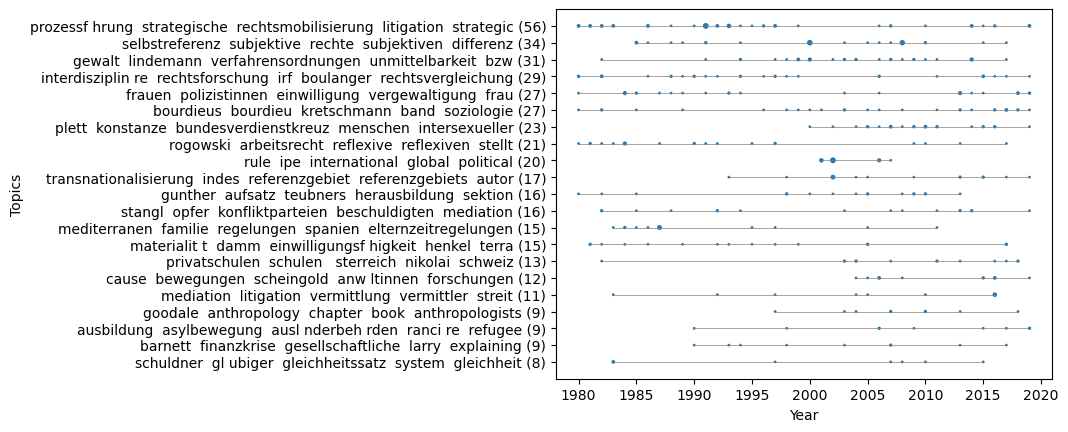

In [85]:
import re
import matplotlib.pyplot as plt

# Calculate total frequency for each topic
total_freq = topics_over_time.groupby('Topic')['Frequency'].sum().sort_values(ascending=False)
total_freq = total_freq.iloc[1:]

# Select the 20 topics with the highest total frequency, excluding the junk topic
top_topics = total_freq.head(21).index

# Filter your data to include only these top 20 topics
filtered_data = topics_over_time[topics_over_time['Topic'].isin(top_topics)].copy()  # Create a copy to avoid SettingWithCopyWarning
lookup_dict = total_freq.to_dict()
filtered_data.loc[:, 'Total_Frequency'] = filtered_data['Topic'].map(lookup_dict)

# Create a mapping of topics numbers to words using the filtered data
topic_num_to_name = {num: re.sub(r'[^a-z]', ' ', name).strip() + f" ({freq})" for num, name, freq in zip(filtered_data['Topic'], filtered_data['Words'], filtered_data['Total_Frequency'])}

# Plot
fig, ax = plt.subplots()
ax.set_xlabel('Year')
ax.set_ylabel('Topics')

scatter = ax.scatter(filtered_data['Timestamp'], filtered_data['Topic'], s=filtered_data['Frequency'])

# Rename y ticks to correspond to actual topic names
plt.yticks(top_topics, [topic_num_to_name[num] for num in top_topics])

# Invert the y-axis so that the topic with the highest total frequency appears at the top
ax.invert_yaxis()

# Create lines for each topic
for t in top_topics:
    data = filtered_data[filtered_data['Topic'] == t][['Timestamp', 'Topic']].sort_values('Timestamp')
    ax.plot(data['Timestamp'], data['Topic'], color='grey', linewidth=0.5)

plt.savefig("docs/zfrsoz-topics-over-time.png", bbox_inches="tight")
plt.show()



## Change of topics over time, with individual timeseries for each decade

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (17).

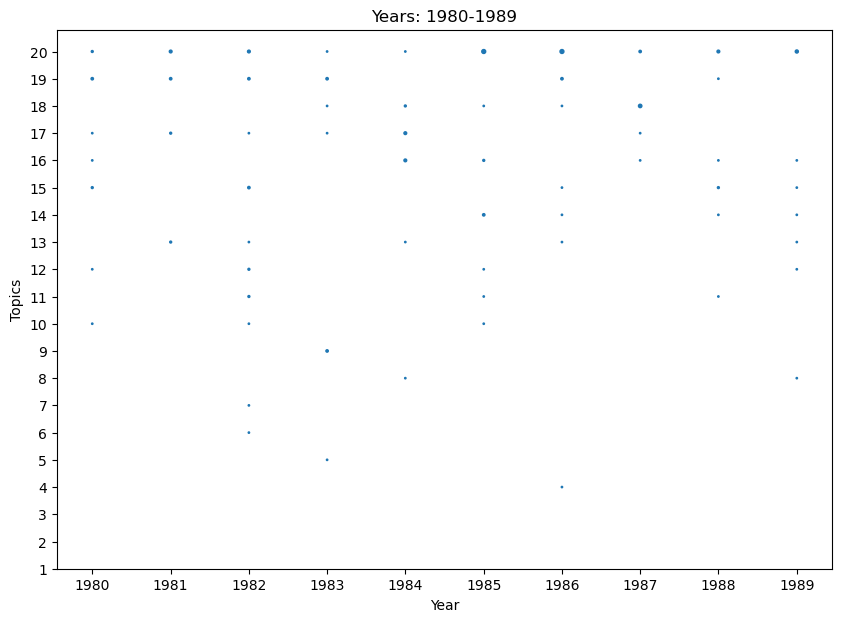

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Convert 'Timestamp' to datetime
topics_over_time['Timestamp'] = pd.to_datetime(topics_over_time['Timestamp'])

# Calculate the year for each row in the data
topics_over_time['Year'] = topics_over_time['Timestamp'].dt.year

# Get the first year and last year
first_year = topics_over_time['Year'].min()
last_year = topics_over_time['Year'].max()

# Create list of "decades" with sliding windows
decades = [(start, start + 10) for start in range(first_year, last_year, 10)]

for i, (start, end) in enumerate(decades):
    # Filter the data for the current "decade"
    data_decade = topics_over_time[(topics_over_time['Year'] >= start) & (topics_over_time['Year'] < end)]

    # Calculate total frequency for each topic in the current "decade"
    total_freq_decade = data_decade.groupby('Topic')['Frequency'].sum().sort_values(ascending=False)

    # Select the top 20 topics from the current "decade"
    top_topics_decade = total_freq_decade.head(20).index

    # Filter data_decade to include only the top 20 topics
    data_decade = data_decade[data_decade['Topic'].isin(top_topics_decade)]

    # Create a mapping of topics numbers to words using the data_decade
    topic_num_to_word = {num: word for num, word in zip(data_decade['Topic'], data_decade['Words'])}

    # Create a new continuous range of numbers for y-axis, but in reversed order
    y_values = range(20, 0, -1)
    topic_to_y_value = {topic: y for topic, y in zip(top_topics_decade, y_values)}

    # Create figure for the plot
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot
    ax.set_title(f'Years: {start}-{end-1}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Topics')
    scatter = ax.scatter(data_decade['Timestamp'], data_decade['Topic'].map(topic_to_y_value), s=data_decade['Frequency'])

    # Rename y ticks to correspond to actual topics
    y_labels = [f'{rank}. {topic_num_to_word[num]}' for rank, num in zip(range(1, 21), top_topics_decade)]
    ax.set_yticks(y_values)
    ax.set_yticklabels(y_labels)

    # Create lines for each topic
    for t in top_topics_decade:
        data = data_decade[data_decade['Topic'] == t].sort_values('Timestamp')
        ax.plot(data['Timestamp'], data['Topic'].map(topic_to_y_value), color='grey', linewidth=0.5)

    # Save the figure
    filename = f'docs/zfrsoz-topics-{start}-{end-1}.png'
    plt.savefig(filename, bbox_inches="tight", dpi=300)

    # Clear the figure
    plt.close(fig)



## Plot document topics

In [ ]:
if os.path.exists('cache/zfrsoz-document-topics.pkl'):
    with open('cache/zfrsoz-document-topics.pkl', 'rb') as f:
        fig_document_topics = pickle.load(f)
else:
    # create document topics, this takes a long time
    fig_document_topics = model.visualize_documents(articles, hide_document_hover=True)
    with open('cache/zfrsoz-document-topics.pkl', 'wb') as f:
        pickle.dump(fig_document_topics, f)
img = fig_document_topics.to_image(format="png", height=800)
with open("docs/zfrsoz-document-topics.png", "wb") as f:
    f.write(img)
fig_document_topics.write_html("docs/zfrsoz-document-topics.html")
display(Image(img))